In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [99]:
f1_results = pd.read_csv("../data/f1_results_features.csv")
f1_laps = pd.read_csv("../data/f1_laps_features.csv")

In [100]:
f1_laps.head()

,Year,Race,Driver,Team,LapNumber,LapTime_seconds,Position,TireCompound,TireAge,PositionGroup,driver_win_rate,start_position,positions_gained,tire_degradation,race_phase,team_reliability
0,2024,1,VER,Red Bull Racing,1.0,97.284,1.0,1.0,4.0,Top 5,0.0,1.0,0.0,-0.016,Early,83.333333
1,2024,1,VER,Red Bull Racing,2.0,96.296,1.0,1.0,5.0,Top 5,0.0,1.0,0.0,-0.988,Early,83.333333
2,2024,1,VER,Red Bull Racing,3.0,96.753,1.0,1.0,6.0,Top 5,0.0,1.0,0.0,0.457,Early,83.333333
3,2024,1,VER,Red Bull Racing,4.0,96.647,1.0,1.0,7.0,Top 5,0.0,1.0,0.0,-0.106,Early,83.333333
4,2024,1,VER,Red Bull Racing,5.0,97.173,1.0,1.0,8.0,Top 5,0.0,1.0,0.0,0.526,Early,83.333333


In [101]:
f1_results.head()

,Year,Race,Driver,Team,Position,GridPosition,Points,Status,PositionChange,driver_win_rate,team_reliability,race_winner,podium_finish,points_finish
0,2024,1,M VERSTAPPEN,Red Bull Racing,1.0,1.0,26.0,Finished,0.0,33.333333,83.333333,1,1,1
1,2024,1,S PEREZ,Red Bull Racing,2.0,5.0,18.0,Finished,3.0,0.000000,83.333333,0,1,1
2,2024,1,C SAINZ,Ferrari,3.0,4.0,15.0,Finished,1.0,6.896552,90.000000,0,1,1
3,2024,1,C LECLERC,Ferrari,4.0,2.0,12.0,Finished,-2.0,10.000000,90.000000,0,0,1
4,2024,1,G RUSSELL,Mercedes,5.0,3.0,10.0,Finished,-2.0,6.666667,91.666667,0,0,1


In [ ]:
# Predicting race winner using multiple models
pre_race_features = ['Team', 'Position', 'GridPosition', 'driver_win_rate', 'team_reliability']

X = f1_results[pre_race_features]
y = f1_results['race_winner']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Team']),
        ('num', 'passthrough', ['Position', 'GridPosition', 'driver_win_rate', 'team_reliability'])
    ]
)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {
    'accuracy': {},
    'f1': {}
}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    cv_accuracy = cross_val_score(model_pipeline, X, y, cv=cv, scoring='accuracy')
    cv_f1 = cross_val_score(model_pipeline, X, y, cv=cv, scoring='f1')
    
    results['accuracy'][name] = cv_accuracy
    results['f1'][name] = cv_f1
    

    print(f"Cross validation accuracy: {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
    print(f"Cross validation F1 score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
    
    model_pipeline.fit(X, y)

summary = pd.DataFrame({
    'Accuracy': {model: results['accuracy'][model].mean() for model in models},
    'F1 Score': {model: results['f1'][model].mean() for model in models}
})

import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the cross-validation results
results_df = pd.DataFrame({
    'Model': [],
    'Metric': [],
    'Score': []
})

for name, model in models.items():
    for metric in ['accuracy', 'f1']:
        for score in results[metric][name]:
            results_df = pd.concat([results_df, pd.DataFrame({
                'Model': [name],
                'Metric': [metric],
                'Score': [score]
            })], ignore_index=True)

plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
sns.boxplot(x='Model', y='Score', data=results_df[results_df['Metric'] == 'accuracy'])
plt.title('Model Comparison by Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# F1 Score plot
plt.subplot(1, 2, 2)
sns.boxplot(x='Model', y='Score', data=results_df[results_df['Metric'] == 'f1'])
plt.title('Model Comparison by F1 Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()



Evaluating Random Forest...
Cross validation accuracy: 1.0000 ± 0.0000
Cross validation F1 score: 1.0000 ± 0.0000

Evaluating Logistic Regression...
Cross validation accuracy: 0.9883 ± 0.0194
Cross validation F1 score: 0.9152 ± 0.1291

Evaluating Gradient Boosting...
Cross validation accuracy: 1.0000 ± 0.0000
Cross validation F1 score: 1.0000 ± 0.0000

Evaluating SVM...
Cross validation accuracy: 0.7847 ± 0.0397
Cross validation F1 score: 0.3155 ± 0.0495



=== MODEL COMPARISON ===
                     Accuracy  F1 Score
Random Forest        1.000000  1.000000
Gradient Boosting    1.000000  1.000000
Logistic Regression  0.988333  0.915152
SVM                  0.784678  0.315541

Best model: Random Forest (F1: 1.0000)


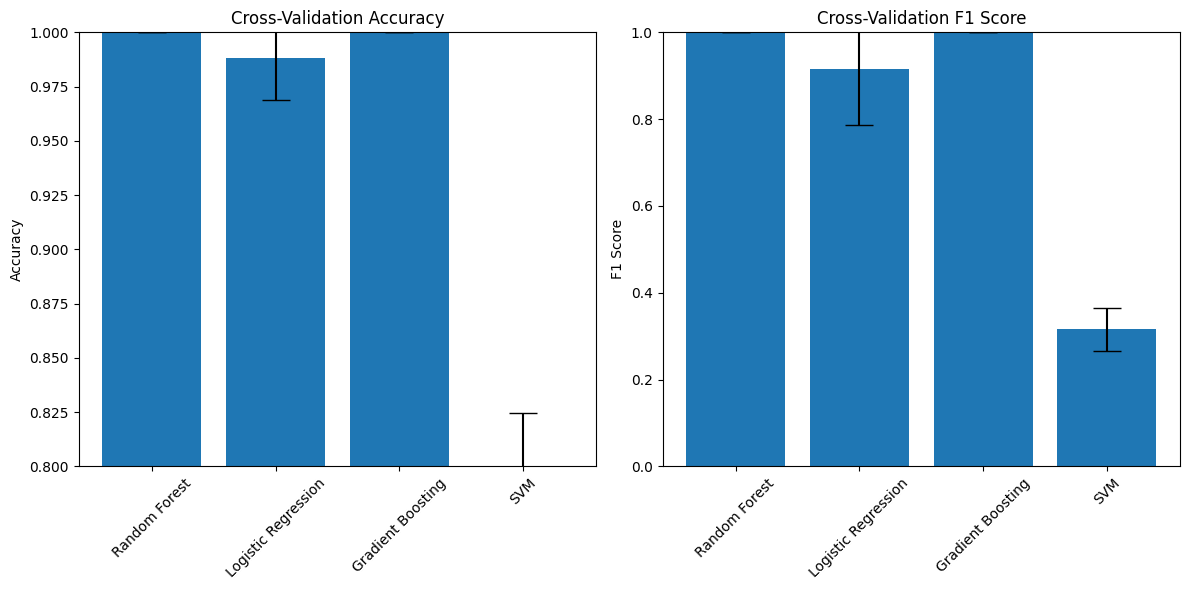

In [103]:
print("\n=== MODEL COMPARISON ===")
print(summary.sort_values('F1 Score', ascending=False))

# Select best model based on F1 score
best_model = summary['F1 Score'].idxmax()
print(f"\nBest model: {best_model} (F1: {summary.loc[best_model, 'F1 Score']:.4f})")

# Plot results
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
model_names = list(models.keys())
accuracy_means = [results['accuracy'][model].mean() for model in model_names]
accuracy_stds = [results['accuracy'][model].std() for model in model_names]

plt.bar(range(len(model_names)), accuracy_means, yerr=accuracy_stds, capsize=10)
plt.xticks(range(len(model_names)), model_names, rotation=45)
plt.title('Cross-Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Adjust as needed


plt.subplot(1, 2, 2)
f1_means = [results['f1'][model].mean() for model in model_names]
f1_stds = [results['f1'][model].std() for model in model_names]

plt.bar(range(len(model_names)), f1_means, yerr=f1_stds, capsize=10)
plt.xticks(range(len(model_names)), model_names, rotation=45)
plt.title('Cross-Validation F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

In [104]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(n_estimators = 1000,
                            learning_rate=0.01,
                            max_depth=4,
                            random_state=42
                            )



pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_classifier)
])

# Train with early stopping
pipeline.fit(X, y)


print(f"Training complete")

Training complete


In [105]:
import pickle

pickle.dump(xgb_classifier , open('../models/xgb_racewin.pk1' , 'wb'))
pickle.dump(pipeline, open('../models/xgb_racewin_pipeline.pk1', 'wb'))